# Example: Using MIRAGE to Generate Moving Target Exposures
### (i.e. Solar System target observations)

The `mirage` simulator is broken up into three basic stages:

1. **Creation of a "seed image".**<br>
   This is generally a noiseless countrate image that contains signal
   only from the astronomical sources to be simulated. Currently, the 
   mirage package contains code to produce a seed image starting
   from object catalogs.<br>
   Note that the much larger amount of data in a
   seed image containing moving targets means that this step will be significantly
   slower than when generating a simple seed image for a sidereal observation.<br><br>
   
2. **Dark current preparation.**<br>
   The simulated data will be created by adding the simulated sources
   in the seed image to a real dark current exposure. This step
   converts the dark current exposure to the requested readout pattern
   and subarray size requested by the user.<br><br>
   
3. **Observation generation.**<br>
   This step converts the seed image into an exposure of the requested
   readout pattern and subarray size. It also adds cosmic rays and 
   Poisson noise, as well as other detector effects (IPC, crosstalk, etc).
   This exposure is then added to the dark current exposure from step 2.<br><br>

*Table of Contents:*
* Single image simulation
    * [Running simulator steps independently](#run_steps_independently)
    * [Running simulator steps together](#run_steps_together)
* [Running multiple simulations](#mult_sims)
* [Generating `yaml` files](#make_yaml)
* [Example `yaml` file](#yaml_example)

---
## Getting Started

<div class="alert alert-block alert-warning">
**Important:** 
Before proceeding, ensure you have set the MIRAGE_DATA environment variable to point to the directory that contains the reference files associated with MIRAGE.
</div>

In [1]:
# Set the MIRAGE_DATA environment variable if it is not
# set already. This is for users at STScI.
import os
#os.environ['MIRAGE_DATA'] = '/myfiles/mirage_data'

In [2]:
# For examining outputs
from glob import glob
from scipy.stats import sigmaclip
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Import the three steps of the simulator. 
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator

---
<a id='run_steps_independently'></a>
# Running simulation steps independently

## First generate the "seed image" 
This is generally a 2D noiseless countrate image that contains only simulated astronomical sources. However, when creating data using non-sidereal tracking or for sidereal tracking where a moving target (e.g. asteroid, KBO) are in the field of view, the seed image will in fact be a 3D seed ramp.

A seed image is generated based on a `.yaml` file that contains all the necessary parameters for simulating data. An example `.yaml` file is show at the [bottom of this notebook](#yaml_example).

In [4]:
# yaml file that contains the parameters of the
# data to be simulated
# Example yaml file shown at the bottom of this
# notebook
yamlfile = 'movingtarget_example_data/moving_target_test.yaml'

In [5]:
cat = catalog_seed_image.Catalog_seed()
cat.paramfile = yamlfile
cat.make_seed()

'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal ramp of synthetic inputs
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /Users/lchambers/TEL/mira

### Look at the seed image

In [6]:
def show(array,title,min=0,max=1000):
    plt.figure(figsize=(12,12))
    plt.imshow(array,clim=(min,max))
    plt.title(title)
    plt.colorbar().set_label('DN/s')
    
def show_mult(array1,array2,array3,title,min=0,max=1000):
    fig = plt.figure(figsize=(18,18))
    a = fig.add_subplot(131)
    aplt = plt.imshow(array1,clim=(min,max))
    b = fig.add_subplot(132)
    bplt = plt.imshow(array2,clim=(min,max))
    plt.title(title)
    c = fig.add_subplot(133)
    cplt = plt.imshow(array3,clim=(min,max))
    #plt.colorbar().set_label('DN/s')

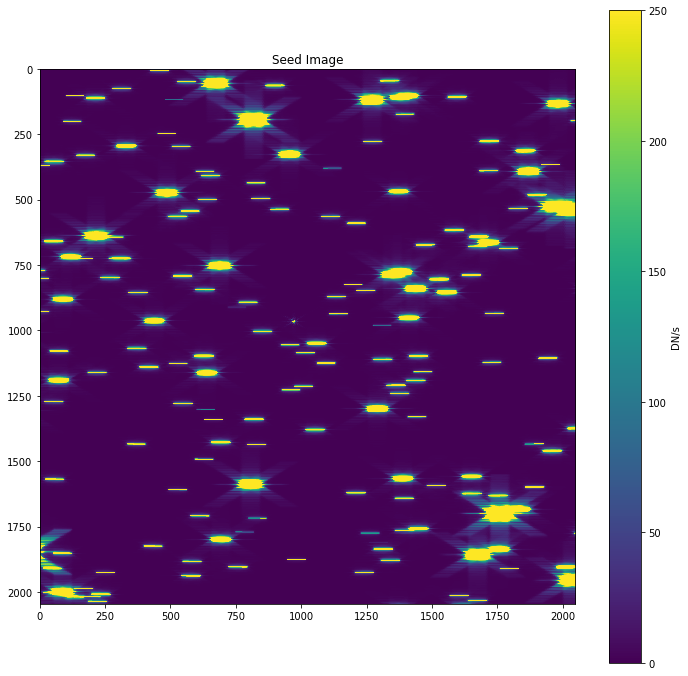

In [7]:
# In this case, the seed image is 4D rather than the
# 2D that it is for sidereal targets.
# So let's look at just the final frame of the seed image

# The non-sidereal target is in the center of the frame and appears
# as a normal PSF (although hard to see in this view). All of the 
# background stars and galaxies are
# smeared, since the telescope was not tracking at the sidereal rate.
show(cat.seedimage[0,-1,:,:],'Seed Image',max=250)

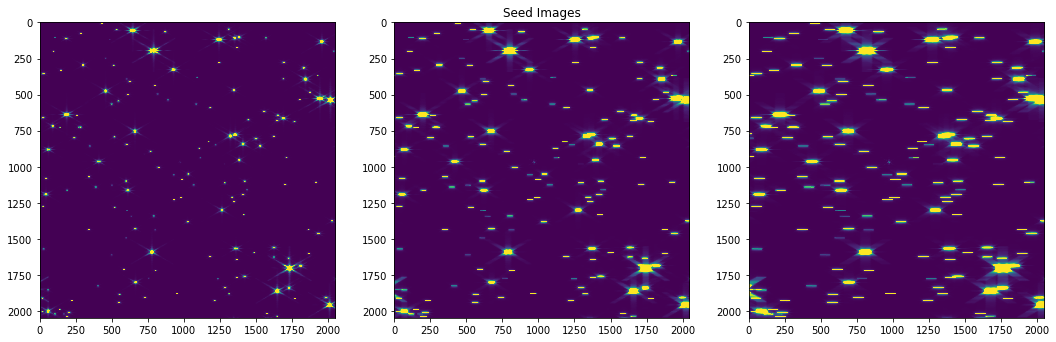

In [8]:
# Look at the first, middle, and last frames of the seed image
# so we can see the background sources moving relative to the target
show_mult(cat.seedimage[0,0,:,:],cat.seedimage[0,3,:,:],cat.seedimage[0,-1,:,:],'Seed Images',max=250)

## Prepare the dark current exposure
This will serve as the base of the simulated data.
This step will linearize the dark current (if it 
is not already), and reorganize it into the 
requested readout pattern and number of groups.

In [9]:
d = dark_prep.DarkPrep()
d.paramfile = yamlfile
d.prepare()

'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/linearity.cfg for newRamp:linear_con

### Look at the dark current 
For this, we will look at an image of the final group
minus the first group

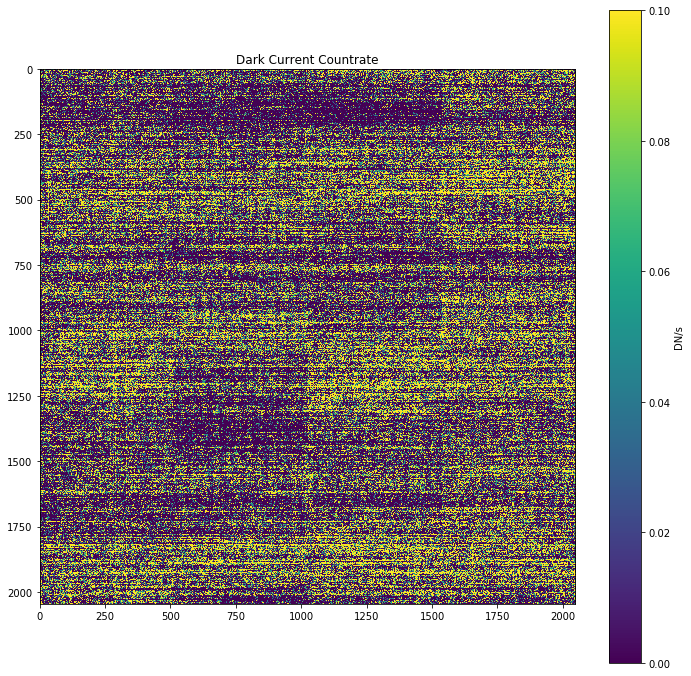

In [10]:
exptime = d.linDark.header['NGROUPS'] * cat.frametime
diff = (d.linDark.data[0,-1,:,:] - d.linDark.data[0,0,:,:]) / exptime
show(diff,'Dark Current Countrate',max=0.1)

## Create the final exposure
Turn the seed image into a exposure of the 
proper readout pattern, and combine it with the
dark current exposure. Cosmic rays and other detector
effects are added. 

The output can be either this linearized exposure, or
a 'raw' exposure where the linearized exposure is 
"unlinearized" and the superbias and 
reference pixel signals are added, or the user can 
request both outputs. This is controlled from
within the yaml parameter file.

In [11]:
obs = obs_generator.Observation()
obs.linDark = d.prepDark
obs.seed = cat.seedimage
obs.segmap = cat.seed_segmap
obs.seedheader = cat.seedinfo
obs.paramfile = yamlfile
obs.create()


Running observation generator....

'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_filter_pupil_pairings.list for Reffiles:filtpupilcombo input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
Requested readout pattern RAPID is valid. Using nframe = 1 and nskip = 0
Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.730773780196465e-06
Integration 0:
Moving target data shape (7, 2048, 2048) 2048 2048
    Averaging frame 0 into group 0
    Avera

WCS info for /Users/lchambers/TEL/mirage/examples/movingtarget_example_data/V12345024002P000000000112o_B5_F250M_movingtarget_linear.fits complete.


Final linearized exposure saved to:
/Users/lchambers/TEL/mirage/examples/movingtarget_example_data/V12345024002P000000000112o_B5_F250M_movingtarget_linear.fits
Observation generation complete.


### Examine the final output image
Look at the last group minus the first group

In [12]:
with fits.open(obs.linear_output) as h:
    lindata = h[1].data
    header = h[0].header

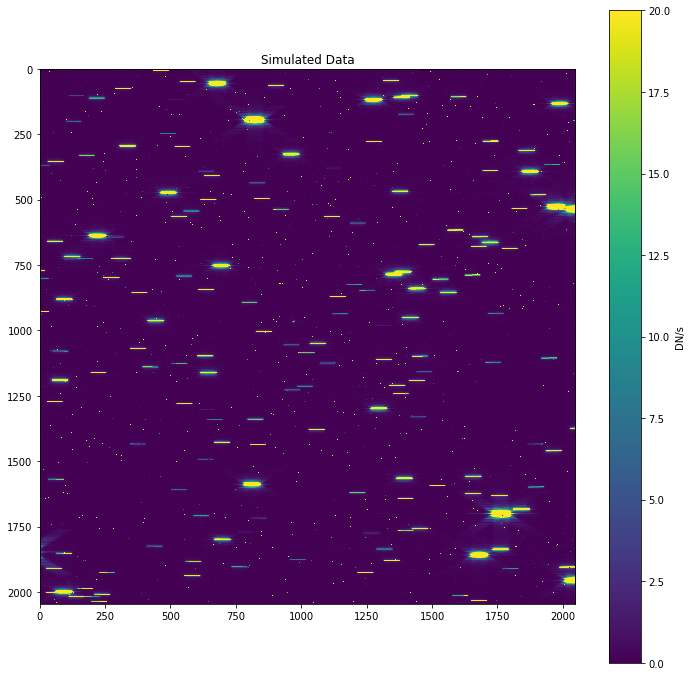

In [13]:
# The central target is difficult to see in this full field view
exptime = header['EFFINTTM']
diffdata = (lindata[0,-1,:,:] - lindata[0,0,:,:]) / exptime
show(diffdata,'Simulated Data',min=0,max=20)

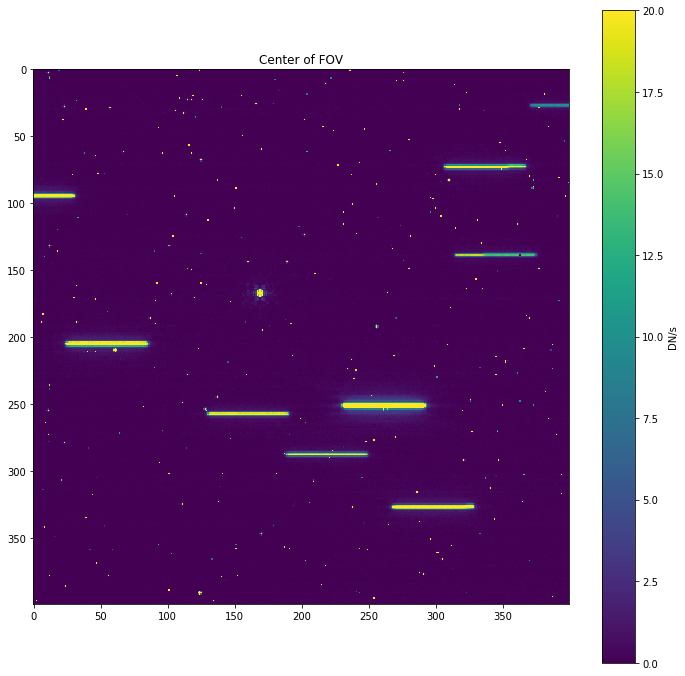

In [14]:
# Zoom in on the center of the field of view, where the target of
# interest lies.
show(diffdata[800:1200,800:1200],'Center of FOV',min=0,max=20)

/Users/lchambers/miniconda3/envs/OTECommSims/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


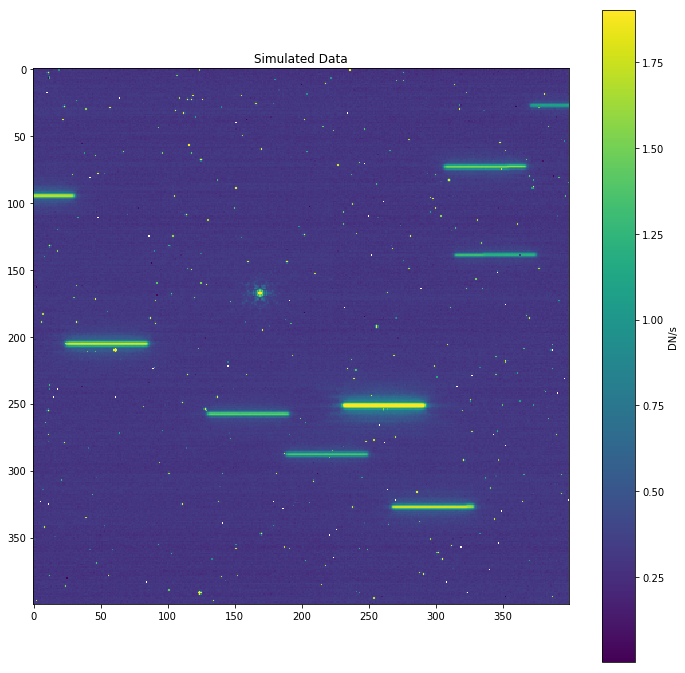

In [15]:
# Show on a log scale, to bring out the presence of the dark current
# Noise in the CDS image makes for a lot of pixels with values < 0,
# which makes this kind of an ugly image. Add an offset so that
# everything is positive and the noise is visible
offset = 2.
plt.figure(figsize=(12,12))
plt.imshow(np.log10(diffdata[800:1200,800:1200]+offset),clim=(0.001,np.log10(80)))
plt.title('Simulated Data')
plt.colorbar().set_label('DN/s')

---
<a id='run_steps_together'></a>
# Running simulation steps together

## For convenience, combine the three steps into a single function.

By having modular steps, the steps can be combined in various ways. For imaging data, including data with non-sidereal or moving targets, we will most likely want to run the three steps above in order for each target. For convenience, the imaging_simulator.py function wraps the three steps together.

In [16]:
from mirage import imaging_simulator

In [17]:
# First, run all steps of the imaging simulator for yaml file #1
m = imaging_simulator.ImgSim()
m.paramfile = 'movingtarget_example_data/moving_target_test.yaml'
m.create()

'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal ramp of synthetic inputs
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /Users/lchambers/TEL/mira

WCS info for /Users/lchambers/TEL/mirage/examples/movingtarget_example_data/V12345024002P000000000112o_B5_F250M_movingtarget_linear.fits complete.


Final linearized exposure saved to:
/Users/lchambers/TEL/mirage/examples/movingtarget_example_data/V12345024002P000000000112o_B5_F250M_movingtarget_linear.fits
Observation generation complete.


If you have multiple exposures that will use the same dark current image (with the same readout pattern, subarray size, and number of groups), you can feed the output from the initial run of `dark_prep` into future runs of the `obs_generator`, to save time. This can be accomplished with the `imaging_simulator.py` code, as shown below.
(Note that time savings are minimal in this case, where the readout pattern is RAPID and there are only a handful of groups. This means that no averaging/skipping of frames has to be done within `dark_prep.py`)

In [18]:
# Now that the linearized dark product has been created, if you want to use it
# when running the simulator with a different yaml file (or repeating the run
# with the same yaml file) you can provide the filename of the dark product, and the
# dark_prep step will be skipped. 
# NOTE: if you use the same dark product for multiple exposures, those exposures
# will contain exactly the same dark signal. This may or may not be advisable, depending
# on your goals for the simulated data.
m = imaging_simulator.ImgSim()
m.paramfile = 'movingtarget_example_data/moving_target_test.yaml'
m.override_dark = 'movingtarget_example_data/V12345024002P000000000112o_B5_F250M_movingtarget_uncal_linear_dark_prep_object.fits'
m.create()

'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/lchambers/TEL/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Frametime is 10.736770000000002
Creating signal ramp of synthetic inputs
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /Users/lchambers/TEL/mira

WCS info for /Users/lchambers/TEL/mirage/examples/movingtarget_example_data/V12345024002P000000000112o_B5_F250M_movingtarget_linear.fits complete.


Final linearized exposure saved to:
/Users/lchambers/TEL/mirage/examples/movingtarget_example_data/V12345024002P000000000112o_B5_F250M_movingtarget_linear.fits
Observation generation complete.


---
<a id='mult_sims'></a>
## Running Multiple Simulations

### Each yaml file, will simulate an exposure for a single pointing using a single detector.

To simulate an exposure using multiple detectors, you must have multiple yaml files. Consider this cumbersome example:
```python
yaml_a1 = 'sim_param_A1.yaml'
yaml_a2 = 'sim_param_A2.yaml'
yaml_a3 = 'sim_param_A3.yaml'
yaml_a4 = 'sim_param_A4.yaml'
yaml_a5 = 'sim_param_A5.yaml'

make_sim(yaml_a1)
make_sim(yaml_a2)
make_sim(yaml_a3)
make_sim(yaml_a4)
make_sim(yaml_a5)
```

This can be performed more efficiently, either in series or in parallel:

### In Series
```python
paramlist = [yaml_a1,yaml_a2,yaml_a3,yaml_a4,yaml_a5]

def many_sim(paramlist):
    '''Function to run many simulations in series
    '''
    for file in paramlist:
        m = imaging_simulator.ImgSim()
        m.paramfile = file
        m.create()
```

### In Parallel

Since each `yaml` simulations does not depend on the others, we can parallelize the process to speed things up:
```python
# Need to test this. May need a wrapper since the 
# imaging simulator is a class

from multiprocessing import Pool

n_procs = 5 # number of cores available

with Pool(n_procs) as pool:
    pool.map(make_sim, paramlist)
```

---
<a id='make_yaml'></a>
## Generating input yaml files

For convenience, observing programs with multiple pointings 
and detectors can be simulated starting with the program's 
APT file. The xml and pointings files must be exported from 
APT, and are then used as input into a tool that will
generate a series of yaml input files.

In [19]:
from mirage.apt import apt_inputs
from mirage.yaml import yaml_generator

In [20]:
# ## Only works for normal imaging, right? Not yet modified for moving targets

# # Create a series of data simluator input yaml files
# # from APT files
# yam = yaml_generator.SimInput()
# yam.input_xml = 'example_imaging_program.xml'
# yam.pointing_file = 'example_imaging_program.pointing'
# yam.siaf = '$MIRAGE_DATA/nircam/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv'
# yam.output_dir = './'
# yam.simdata_output_dir = './'
# yam.observation_table = 'observation_list.yaml'
# yam.use_JWST_pipeline = True
# yam.use_linearized_darks = False
# yam.datatype = 'linear'
# yam.reffile_setup(instrument='nircam')
# yam.create_inputs()

In [21]:
# yfiles = glob(os.path.join(yam.output_dir,'V*yaml'))

In [22]:
# m = imaging_simulator.ImgSim()
# m.paramfile = yfiles[0]
# m.create()

--- 
<a id='yaml_example'></a>
## Example yaml input file

Entries listed as 'config' have default files that are present in the 
config directory of the repository. The scripts are set up to 
automatically find and use these files. The user can replace 'config'
with a filename if they wish to override the default.

In general, if 'None' is placed in a field, then the step that uses
that particular file will be skipped.

Note that the linearized_darkfile entry overrides the dark entry, unless
linearized_darkfile is set to None, in which case the dark entry will be
used.

Use of a valid readout pattern in the readpatt entry will cause the 
simulator to look up the values of nframe and nskip and ignore the 
values given in the yaml file.

```yaml
Inst:
  instrument: NIRCam          #Instrument name
  mode: imaging               #Observation mode (e.g. imaging, WFSS, moving_target)
  use_JWST_pipeline: False   #Use pipeline in data transformations

Readout:
  readpatt: RAPID  #Readout pattern (RAPID, BRIGHT2, etc) overrides nframe,nskip unless it is not recognized
  nframe: 1        #Number of frames per group
  nint: 1          #Number of integrations per exposure
  resets_bet_ints: 1 #Number of detector resets between integrations
  array_name: NRCB5_FULL    #Name of array (FULL, SUB160, SUB64P, etc)
  filter: F250M       #Filter of simulated data (F090W, F322W2, etc)
  pupil: CLEAR        #Pupil element for simulated data (CLEAR, GRISMC, etc)

Reffiles:                                 #Set to None or leave blank if you wish to skip that step
  dark: None   #Dark current integration used as the base
  linearized_darkfile: $MIRAGE_DATA/nircam/darks/linearized/B5/Linearized_Dark_and_SBRefpix_NRCNRCBLONG-DARK-60090141241_1_490_SE_2016-01-09T02h46m50_uncal.fits # Linearized dark ramp to use as input. Supercedes dark above
  badpixmask: $MIRAGE_DATA/nircam/reference_files/badpix/NRCB5_17161_BPM_ISIMCV3_2016-01-21_ssbspmask_DMSorient.fits # If linearized dark is used, populate output DQ extensions using this file
  superbias: $MIRAGE_DATA/nircam/reference_files/superbias/NRCB5_superbias_from_list_of_biasfiles.list.fits  #Superbias file. Set to None or leave blank if not using
  linearity: $MIRAGE_DATA/nircam/reference_files/linearity/NRCBLONG_17161_LinearityCoeff_ADU0_2016-05-22_ssblinearity_v2_DMSorient.fits    #linearity correction coefficients
  saturation: $MIRAGE_DATA/nircam/reference_files/saturation/NRCB5_17161_WellDepthADU_2016-03-10_ssbsaturation_wfact_DMSorient.fits    #well depth reference files
  gain: $MIRAGE_DATA/nircam/reference_files/gain/NRCB5_17161_Gain_ISIMCV3_2016-02-25_ssbgain_DMSorient.fits #Gain map
  pixelflat: None 
  illumflat: None                               #Illumination flat field file
  astrometric: $MIRAGE_DATA/nircam/reference_files/distortion/NRCB5_FULL_distortion.asdf  #Astrometric distortion file (asdf)
  distortion_coeffs: $MIRAGE_DATA/nircam/reference_files/SIAF/NIRCam_SIAF_2017-03-28.csv        #CSV file containing distortion coefficients
  ipc: $MIRAGE_DATA/nircam/reference_files/ipc/NRCB5_17161_IPCDeconvolutionKernel_2016-03-18_ssbipc_DMSorient.fits #File containing IPC kernel to apply
  invertIPC: True       #Invert the IPC kernel before the convolution. True or False. Use True if the kernel is designed for the removal of IPC effects, like the JWST reference files are.
  occult: None                                    #Occulting spots correction image
  pixelAreaMap: $MIRAGE_DATA/nircam/reference_files/pam/NIRCam_B5_PAM_imaging.fits #Pixel area map for the detector. Used to introduce distortion into the output ramp.
  subarray_defs:   config   #File that contains a list of all possible subarray names and coordinates
  readpattdefs:    config   #File that contains a list of all possible readout pattern names and associated NFRAME/NSKIP values
  crosstalk:       config   #File containing crosstalk coefficients
  filtpupilcombo:  config   #File that lists the filter wheel element / pupil wheel element combinations. Used only in writing output file
  flux_cal:        config   #File that lists flux conversion factor and pivot wavelength for each filter. Only used when making direct image outputs to be fed into the grism disperser code.
  
nonlin:
  limit: 60000.0                           #Upper singal limit to which nonlinearity is applied (ADU)
  accuracy: 0.000001                        #Non-linearity accuracy threshold
  maxiter: 10                              #Maximum number of iterations to use when applying non-linearity
  robberto:  False                         #Use Massimo Robberto type non-linearity coefficients

cosmicRay:
  path: $MIRAGE_DATA/nircam/cosmic_ray_library/         #Path to CR library
  library: SUNMIN    #Type of cosmic rayenvironment (SUNMAX, SUNMIN, FLARE)
  scale: 1.5     #Cosmic ray scaling factor
  suffix: IPC_NIRCam_B5    #Suffix of library file names
  seed: 2956411739      #Seed for random number generator

simSignals:
  pointsource: my_ptsrc_catalog.list #File containing a list of point sources to add (x,y locations and magnitudes)
  psfpath: $MIRAGE_DATA/nircam/psf_data/        #Path to PSF library
  psfbasename: nircam                        #Basename of the files in the psf library
  psfpixfrac: 0.25                           #Fraction of a pixel between entries in PSF library (e.g. 0.1 = files for PSF centered at 0.25 pixel intervals within pixel)
  psfwfe: predicted                          #PSF WFE value (predicted, requirements)
  psfwfegroup: 0                             #WFE realization group (0 to 9)
  galaxyListFile: my_galaxies_catalog.list
  extended: None          #Extended emission count rate image file name
  extendedscale: 1.0         #Scaling factor for extended emission image
  extendedCenter: 1024,1024  #x,y pixel location at which to place the extended image if it is smaller than the output array size
  PSFConvolveExtended: True #Convolve the extended image with the PSF before adding to the output image (True or False)
  movingTargetList: None   #Name of file containing a list of point source moving targets (e.g. KBOs, asteroids) to add.
  movingTargetSersic: None  #ascii file containing a list of 2D sersic profiles to have moving through the field
  movingTargetExtended: None      #ascii file containing a list of stamp images to add as moving targets (planets, moons, etc)
  movingTargetConvolveExtended: True       #convolve the extended moving targets with PSF before adding.
  movingTargetToTrack: my_nonsidereal_target.cat #File containing a single moving target which JWST will track during observation (e.g. a planet, moon, KBO, asteroid)	This file will only be used if mode is set to "moving_target" 
  zodiacal:  None                          #Zodiacal light count rate image file 
  zodiscale:  1.0                            #Zodi scaling factor
  scattered:  None                          #Scattered light count rate image file
  scatteredscale: 1.0                        #Scattered light scaling factor
  bkgdrate: 0.0                         #Constant background count rate (electrons/sec/pixel)
  poissonseed: 2012872553                  #Random number generator seed for Poisson simulation)
  photonyield: True                         #Apply photon yield in simulation
  pymethod: True                            #Use double Poisson simulation for photon yield

Telescope:
  ra: 53.1                     #RA of simulated pointing
  dec: -27.8                   #Dec of simulated pointing
  rotation: 0.0                #y axis rotation (degrees E of N)
  tracking: non-sidereal        #sidereal or non-sidereal
  
newRamp:
  dq_configfile: config          #config file used by JWST pipeline
  sat_configfile: config         #config file used by JWST pipeline
  superbias_configfile: config   #config file used by JWST pipeline
  refpix_configfile: config      #config file used by JWST pipeline 
  linear_configfile: config      #config file used by JWST pipeline

Output:
  file: V42424024002P000000000112o_B5_F250M_uncal.fits   #Output filename
  directory: ./   # Directory in which to place output files
  datatype: linear,raw # Type of data to save. 'linear' for linearized ramp. 'raw' for raw ramp. 'linear,raw' for both
  format: DMS          #Output file format Options: DMS, SSR(not yet implemented)
  save_intermediates: False   #Save intermediate products separately (point source image, etc)
  grism_source_image: False   # Create an image to be dispersed?
  unsigned: True   #Output unsigned integers? (0-65535 if true. -32768 to 32768 if false)
  dmsOrient: True    #Output in DMS orientation (vs. fitswriter orientation).
  program_number: 42424    #Program Number
  title: Supernovae and Black Holes Near Hyperspatial Bypasses   #Program title
  PI_Name: Doug Adams  #Proposal PI Name
  Proposal_category: GO  #Proposal category
  Science_category: Cosmology  #Science category
  observation_number: '002'    #Observation Number
  observation_label: Obs2    #User-generated observation Label
  visit_number: '024'    #Visit Number
  visit_group: '01'    #Visit Group
  visit_id: '42424024002'    #Visit ID
  sequence_id: '2'    #Sequence ID
  activity_id: '2o'    #Activity ID. Increment with each exposure.
  exposure_number: '00001'    #Exposure Number
  obs_id: 'V42424024002P000000000112o'   #Observation ID number
  date_obs: '2019-10-15'  #Date of observation
  time_obs: '06:29:11.852'  #Time of observation
  obs_template: 'NIRCam Imaging'  #Observation template
  primary_dither_type: NONE  #Primary dither pattern name
  total_primary_dither_positions: 1  #Total number of primary dither positions
  primary_dither_position: 1  #Primary dither position number
  subpix_dither_type: 2-POINT-MEDIUM-WITH-NIRISS  #Subpixel dither pattern name
  total_subpix_dither_positions: 2  #Total number of subpixel dither positions
  subpix_dither_position: 2  #Subpixel dither position number
  xoffset: 344.284  #Dither pointing offset in x (arcsec)
  yoffset: 466.768  #Dither pointing offset in y (arcsec)
```